<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_AE/GRU_AE_Bund10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 1.94 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 12:31:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Bund10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 7.7 MB/s 
     |████████████████████████████████| 97 kB 8.7 MB/s 
     |████████████████████████████████| 170 kB 54.9 MB/s 
     |████████████████████████████████| 138 kB 49.4 MB/s 
     |████████████████████████████████| 133 kB 57.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

     # layer 1
    model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(GRU(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(GRU(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: tk1cssta
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_AE/sweeps/tk1cssta


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: xmprpipx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
8/8 [==============================] - 26s 292ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - mean_absolute_error: 0.2788 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1084
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1306 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1108
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0790 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0790
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0641 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0668
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0027 - mean_squared_error: 0

wandb: Agent Starting Run: ial4mz3z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 8s 64ms/step - loss: 1.0095 - mean_squared_error: 1.0095 - mean_absolute_error: 0.5834 - val_loss: 0.0523 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1791
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1250 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0810
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1028 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1171
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1150 - val_loss: 0.0647 - val_mean_squared_error: 0.0647 - val_mean_absolute_error: 0.1987
Epoch 5/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0235 - mean_squared_error

wandb: Agent Starting Run: go2kvon8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 22s 305ms/step - loss: 0.1044 - mean_squared_error: 0.1044 - mean_absolute_error: 0.2578 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0975
Epoch 2/100
32/32 [==============================] - 8s 256ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0570 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0708
Epoch 3/100
32/32 [==============================] - 8s 258ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0459 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0766
Epoch 4/100
32/32 [==============================] - 9s 276ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0462 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0868
Epoch 5/100
32/32 [==============================] - 9s 267ms/step - loss: 0.0037 - mean_sq

wandb: Agent Starting Run: t3ictk0p with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 507ms/step - loss: 0.1328 - mean_squared_error: 0.1328 - mean_absolute_error: 0.3031 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1454
Epoch 2/100
8/8 [==============================] - 2s 263ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1043 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0897
Epoch 3/100
8/8 [==============================] - 2s 262ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0658 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0681
Epoch 4/100
8/8 [==============================] - 2s 272ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0462 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0697
Epoch 5/100
8/8 [==============================] - 2s 253ms/step - loss: 0.0045 - mean_squared_erro

wandb: Agent Starting Run: w0qryy7n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 14s 431ms/step - loss: 0.1022 - mean_squared_error: 0.1022 - mean_absolute_error: 0.2527 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1317
Epoch 2/200
16/16 [==============================] - 4s 277ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0901 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0694
Epoch 3/200
16/16 [==============================] - 4s 272ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0464 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0665
Epoch 4/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0426 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0630
Epoch 5/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0028 - mean_sq

wandb: Agent Starting Run: 8z31zjjv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 8s 61ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - mean_absolute_error: 0.1584 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0753
Epoch 2/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0377 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0583
Epoch 3/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0333 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0574
Epoch 4/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0308 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0584
Epoch 5/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0016 - mean_squared_

wandb: Agent Starting Run: nhoy7eki with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 17s 313ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1439 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0698
Epoch 2/50
32/32 [==============================] - 9s 275ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0562 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0681
Epoch 3/50
32/32 [==============================] - 9s 278ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0517 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0645
Epoch 4/50
32/32 [==============================] - 9s 269ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0717
Epoch 5/50
32/32 [==============================] - 8s 250ms/step - loss: 0.0040 - mean_squared

wandb: Agent Starting Run: 8rk3ly3a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 111ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - mean_absolute_error: 0.2060 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0809
Epoch 2/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0525 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0681
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0379 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0523
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0270 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0496
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0012 - mean_squared

wandb: Agent Starting Run: tkcsut2p with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 12s 533ms/step - loss: 0.1440 - mean_squared_error: 0.1440 - mean_absolute_error: 0.3196 - val_loss: 0.1333 - val_mean_squared_error: 0.1333 - val_mean_absolute_error: 0.2998
Epoch 2/100
8/8 [==============================] - 2s 280ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - mean_absolute_error: 0.1873 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1482
Epoch 3/100
8/8 [==============================] - 2s 273ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1473 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1403
Epoch 4/100
8/8 [==============================] - 2s 258ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1150 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1470
Epoch 5/100
8/8 [==============================] - 2s 259ms/step - loss: 0.0175 - mean_squared_erro

wandb: Agent Starting Run: bdsv9ut3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 9s 121ms/step - loss: 0.0764 - mean_squared_error: 0.0764 - mean_absolute_error: 0.2115 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1176
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0708 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0678
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0381 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0652
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0351 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0622
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0019 - mean_squared_erro

wandb: Agent Starting Run: 2i4ebl9j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 109ms/step - loss: 0.0917 - mean_squared_error: 0.0917 - mean_absolute_error: 0.2257 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0644
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0656 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1017
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0632 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0669
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0499 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0547
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0033 - mean_squared

wandb: Agent Starting Run: qxewfyhe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 9s 66ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1656 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0691
Epoch 2/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0486 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0663
Epoch 3/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0443 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0620
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0383 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0623
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0024 - mean_squared_error

wandb: Agent Starting Run: yurlgzo4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 12s 516ms/step - loss: 0.1012 - mean_squared_error: 0.1012 - mean_absolute_error: 0.2575 - val_loss: 0.0982 - val_mean_squared_error: 0.0982 - val_mean_absolute_error: 0.2472
Epoch 2/100
8/8 [==============================] - 2s 273ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - mean_absolute_error: 0.1669 - val_loss: 0.0506 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1831
Epoch 3/100
8/8 [==============================] - 2s 275ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1560 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1679
Epoch 4/100
8/8 [==============================] - 2s 291ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1331 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0988
Epoch 5/100
8/8 [==============================] - 2s 264ms/step - loss: 0.0110 - mean_squared_erro

wandb: Agent Starting Run: u933zfv7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 19s 337ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1583 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0721
Epoch 2/50
32/32 [==============================] - 8s 259ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0803 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0631
Epoch 3/50
32/32 [==============================] - 8s 262ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0572 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0572
Epoch 4/50
32/32 [==============================] - 8s 259ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0394 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0725
Epoch 5/50
32/32 [==============================] - 8s 257ms/step - loss: 0.0052 - mean_squared

wandb: Agent Starting Run: rrrpet3d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 9s 228ms/step - loss: 0.1267 - mean_squared_error: 0.1267 - mean_absolute_error: 0.2868 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1094
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0914 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0853
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0644 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0704
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0504 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0650
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0034 - mean_squared_error: 0.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ykvsx4l5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 111ms/step - loss: 0.1457 - mean_squared_error: 0.1457 - mean_absolute_error: 0.2542 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.2102
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0845 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0825
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0682 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0539
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0470 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0576
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0030 - mean_squared

wandb: Agent Starting Run: bohwpqn6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 12s 503ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - mean_absolute_error: 0.3000 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1518
Epoch 2/50
8/8 [==============================] - 2s 262ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1080 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0975
Epoch 3/50
8/8 [==============================] - 2s 285ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0611 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1592
Epoch 4/50
8/8 [==============================] - 2s 265ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0679
Epoch 5/50
8/8 [==============================] - 2s 264ms/step - loss: 0.0054 - mean_squared_error: 0.

wandb: Agent Starting Run: 3anxpy4r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 13s 393ms/step - loss: 0.1273 - mean_squared_error: 0.1273 - mean_absolute_error: 0.2995 - val_loss: 0.0546 - val_mean_squared_error: 0.0546 - val_mean_absolute_error: 0.1825
Epoch 2/200
16/16 [==============================] - 4s 276ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1321 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1444
Epoch 3/200
16/16 [==============================] - 4s 282ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0997 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0847
Epoch 4/200
16/16 [==============================] - 4s 280ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0551 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0761
Epoch 5/200
16/16 [==============================] - 4s 259ms/step - loss: 0.0034 - mean_sq

wandb: Agent Starting Run: jfq0hsq6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 131ms/step - loss: 0.0615 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1653 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0710
Epoch 2/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0519 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0621
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0388 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0654
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0374 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0817
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0044 - mean_squared_erro

wandb: Agent Starting Run: 8lfwq1jw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 113ms/step - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_error: 0.1865 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0788
Epoch 2/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0723 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0836
Epoch 3/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0493 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0611
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0381 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0572
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0024 - mean_squared

wandb: Agent Starting Run: nb9p0tjt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 17s 309ms/step - loss: 0.0644 - mean_squared_error: 0.0644 - mean_absolute_error: 0.1833 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0709
Epoch 2/50
32/32 [==============================] - 9s 267ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0486 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0888
Epoch 3/50
32/32 [==============================] - 9s 268ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0474 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0657
Epoch 4/50
32/32 [==============================] - 9s 268ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0385 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0681
Epoch 5/50
32/32 [==============================] - 9s 274ms/step - loss: 0.0043 - mean_squared

wandb: Agent Starting Run: 5j5o77em with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 10s 116ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1593 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0754
Epoch 2/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0723 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0673
Epoch 3/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0439 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0617
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0400 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0786
Epoch 5/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0031 - mean_square

wandb: Agent Starting Run: 861cgzbf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 9s 65ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1599 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0660
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0362 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0610
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0323 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0633
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0304 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0595
Epoch 5/50
32/32 [==============================] - 0s 16ms/step - loss: 0.0016 - mean_squared_error

wandb: Agent Starting Run: ommia7ei with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 15s 414ms/step - loss: 0.1046 - mean_squared_error: 0.1046 - mean_absolute_error: 0.2600 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1145
Epoch 2/100
16/16 [==============================] - 4s 265ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0774 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0706
Epoch 3/100
16/16 [==============================] - 4s 258ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0456 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0885
Epoch 4/100
16/16 [==============================] - 4s 261ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0597 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0629
Epoch 5/100
16/16 [==============================] - 4s 269ms/step - loss: 0.0026 - mean_sq

wandb: Agent Starting Run: p54vjfwf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 18s 329ms/step - loss: 0.1980 - mean_squared_error: 0.1980 - mean_absolute_error: 0.3001 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0987
Epoch 2/200
32/32 [==============================] - 9s 272ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0926 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0879
Epoch 3/200
32/32 [==============================] - 9s 269ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0901 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1104
Epoch 4/200
32/32 [==============================] - 9s 270ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0833 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.2362
Epoch 5/200
32/32 [==============================] - 8s 261ms/step - loss: 0.0159 - mean_sq

wandb: Agent Starting Run: chjjos29 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 9s 67ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1422 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0636
Epoch 2/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0466 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0609
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0360 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0592
Epoch 4/200
32/32 [==============================] - 1s 29ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0362 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0583
Epoch 5/200
32/32 [==============================] - 1s 19ms/step - loss: 0.0019 - mean_squared_

wandb: Agent Starting Run: che6mr3j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 60ms/step - loss: 0.3861 - mean_squared_error: 0.3861 - mean_absolute_error: 0.4139 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0739
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1081 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0652
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0934 - val_loss: 0.0784 - val_mean_squared_error: 0.0784 - val_mean_absolute_error: 0.2186
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1058 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1808
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0121 - mean_squared_

wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: pa74pbd4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 19s 344ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1467 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0696
Epoch 2/50
32/32 [==============================] - 9s 273ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0507 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1014
Epoch 3/50
32/32 [==============================] - 9s 275ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0561 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0626
Epoch 4/50
32/32 [==============================] - 9s 287ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0543 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0768
Epoch 5/50
32/32 [==============================] - 9s 274ms/step - loss: 0.0036 - mean_squared

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'dropout': 0.1,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(GRU(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(GRU(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  187137


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
10/10 [==============================] - 6s 11ms/step - loss: 0.0743
Epoch 2/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0096
Epoch 3/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 4/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 5/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 6/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 7/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 8/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 9/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 10/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 11/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 12/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 13/200
10/10 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

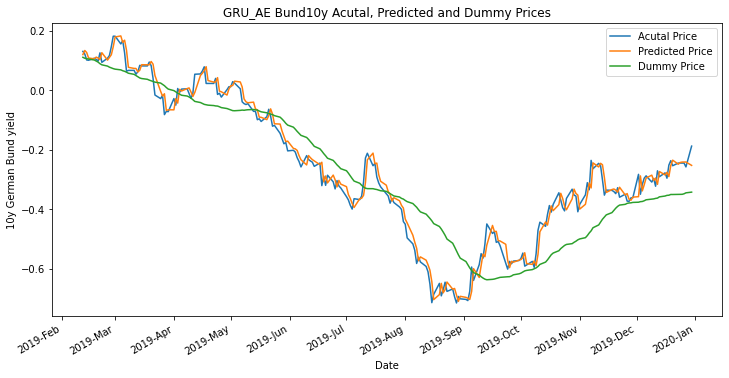

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

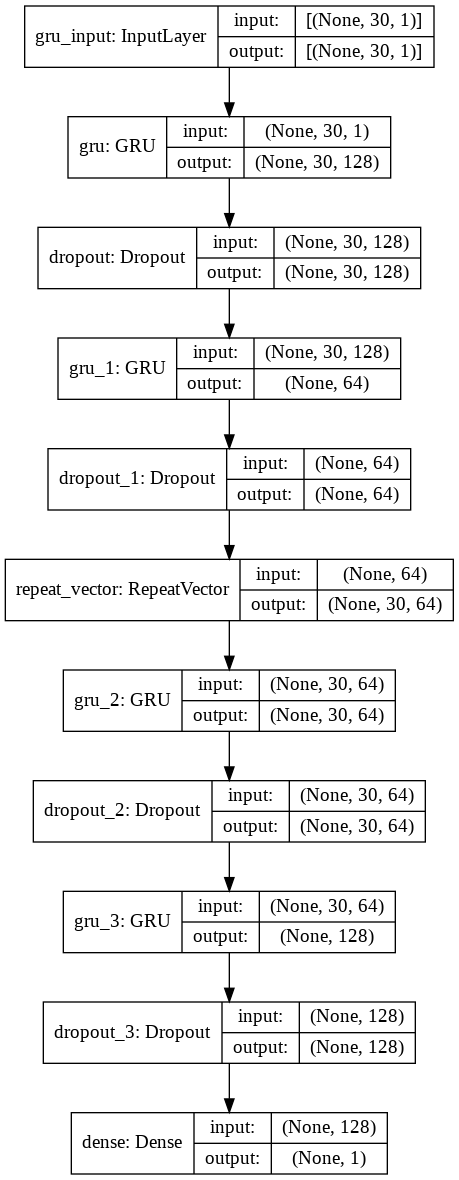

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003328180056412892
RMSE:  0.05769038096955932
MAE:  0.04791090875875582
Dummy MSE:  0.01192499274023522
Dummy RMSE:  0.10920161509902324
Dummy MAE:  0.0887186459104488


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Bund10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Bund10y/assets
